In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import yfinance as yf
from backtesting import Backtest, Strategy
import multiprocessing
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

# (Important if on Linux or certain OSes)
multiprocessing.set_start_method('fork', force=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Stratergy and Signal logic

This is just copy and pasted from a previous code as the stratergy is not the focus of this code

In [2]:
def apply_total_signal(df, rsi_threshold_low=30, rsi_threshold_high=70, bb_width_threshold=0.0015):
    signals = np.zeros(len(df))
    
    prev_close = df['Close'].shift(1)
    prev_high = df['High'].shift(1)
    prev_low = df['Low'].shift(1)
    
    buy_conditions = (
        (prev_close < df['BBL'].shift(1)) &
        (df['RSI'].shift(1) < rsi_threshold_low) &
        (df['Close'] > prev_high) &
        (df['BBB'] > bb_width_threshold)
    )
    
    sell_conditions = (
        (prev_close > df['BBU'].shift(1)) &
        (df['RSI'].shift(1) > rsi_threshold_high) &
        (df['Close'] < prev_low) &
        (df['BBB'] > bb_width_threshold)
    )
    
    signals[buy_conditions] = 2  # buy
    signals[sell_conditions] = 1  # sell
    
    return pd.Series(signals, index=df.index)

class MyStrat(Strategy):
    mysize = 0.1
    slcoef = 3.0
    TPcoef = 2.0
    rsi_threshold_low = 30
    rsi_threshold_high = 70
    bb_width_threshold = 0.0015
    
    def init(self):
        super().init()
        self.signal1 = self.I(self.calculate_signal)

    def calculate_signal(self):
        return apply_total_signal(
            df=self.data.df,
            rsi_threshold_low=self.rsi_threshold_low,
            rsi_threshold_high=self.rsi_threshold_high,
            bb_width_threshold=self.bb_width_threshold
        )

    def next(self):
        super().next()
        
        if not self.position:
            slatr = self.slcoef * self.data.ATR[-1]
            tpatr = self.TPcoef * self.data.ATR[-1]
            
            if self.signal1[-1] == 2:  # Buy
                sl1 = self.data.Close[-1] - slatr
                tp1 = self.data.Close[-1] + tpatr
                self.buy(sl=sl1, tp=tp1, size=self.mysize)
                
            elif self.signal1[-1] == 1:  # Sell
                sl1 = self.data.Close[-1] + slatr
                tp1 = self.data.Close[-1] - tpatr
                self.sell(sl=sl1, tp=tp1, size=self.mysize)

## Function to run backtest on a single ticker

In [3]:
def run_backtest_for_ticker(ticker, start='2019-01-01', end='2022-12-31'):
    print(f"\n=== Backtesting {ticker} ===")
    df = yf.download(tickers=ticker, start=start, end=end)
    if df.empty:
        print(f"No data for {ticker}")
        return None
    
    # Standardize columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [' '.join(col).strip() for col in df.columns]
    df.columns = [col.split(' ')[0] for col in df.columns]
    
    # Indicators
    df['RSI'] = ta.rsi(close=df['Close'], length=14)
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    bbands = ta.bbands(close=df['Close'], length=30, std=2)
    if isinstance(bbands, pd.DataFrame):
        df['BBL'] = bbands['BBL_30_2.0']
        df['BBM'] = bbands['BBM_30_2.0']
        df['BBU'] = bbands['BBU_30_2.0']
        df['BBB'] = (df['BBU'] - df['BBL']) / df['BBM']
    
    df.dropna(inplace=True)
    
    # Backtest
    bt = Backtest(df, MyStrat, cash=10000, margin=1/10, commission=0.001)
    stats = bt.optimize(
       rsi_threshold_low=[25, 30, 35],
       rsi_threshold_high=[65, 70, 75],
       bb_width_threshold=[0.001, 0.002, 0.005],
       slcoef=[2.0, 3.0],
       TPcoef=[2.0, 3.0],
       maximize='Return [%]'
    )
    
    return (ticker, stats, bt)

## Run for multiple tickers

In [4]:
tickers = ["AAPL", "AMZN", "TSLA", "NVDA"]
results = []

for tk in tickers:
    out = run_backtest_for_ticker(tk)
    if out is not None:
        results.append(out)

if not results:
    print("No successful backtests to display.")


=== Backtesting AAPL ===


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=== Backtesting AMZN ===



[*********************100%***********************]  1 of 1 completed


=== Backtesting TSLA ===



[*********************100%***********************]  1 of 1 completed


=== Backtesting NVDA ===


## Plot each ticker in one figure (subplots)



===== AAPL results =====
Start                     2019-02-13 00:00...
End                       2022-12-30 00:00...
Duration                   1416 days 00:00:00
Exposure Time [%]                     0.81716
Equity Final [$]                  9251.982147
Equity Peak [$]                   10051.15103
Return [%]                          -7.480179
Buy & Hold Return [%]              205.394284
Return (Ann.) [%]                   -1.981366
Volatility (Ann.) [%]                2.335531
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -7.951019
Avg. Drawdown [%]                   -7.951019
Max. Drawdown Duration     1157 days 00:00:00
Avg. Drawdown Duration     1157 days 00:00:00
# Trades                                    3
Win Rate [%]                              0.0
Best Trade [%]                      -2.445183
Worst Trade [%]                     -2.800504
Avg. Tra

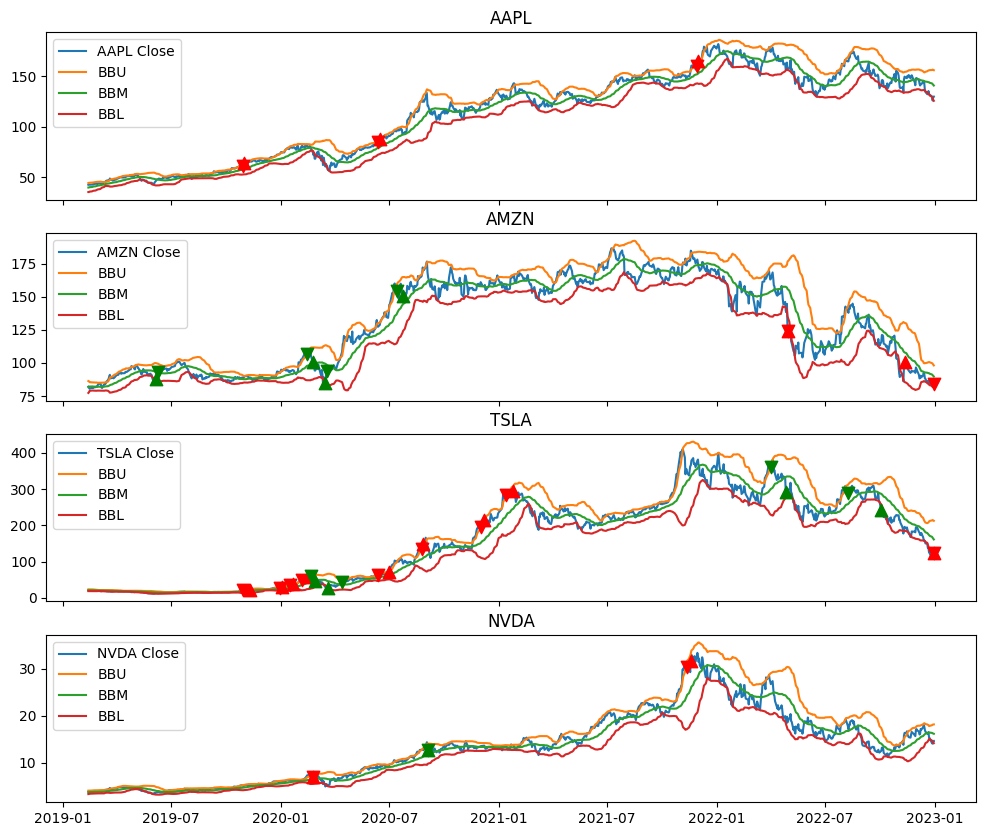

In [5]:
fig, axes = plt.subplots(len(results), 1, figsize=(12, 10), sharex=True)
if len(results) == 1:
    axes = [axes]  # So we can iterate the same way

for ax, (ticker, stats, bt) in zip(axes, results):
    # Print the stats
    print(f"\n===== {ticker} results =====")
    print(stats)
    print("Optimal Parameters:")
    print(f"  RSI Low:        {stats._strategy.rsi_threshold_low}")
    print(f"  RSI High:       {stats._strategy.rsi_threshold_high}")
    print(f"  BB Width:       {stats._strategy.bb_width_threshold}")
    print(f"  SL Coefficient: {stats._strategy.slcoef}")
    print(f"  TP Coefficient: {stats._strategy.TPcoef}")

    # Price & bands
    df = bt._data
    ax.plot(df.index, df['Close'], label=f"{ticker} Close")
    ax.plot(df.index, df['BBU'], label="BBU")
    ax.plot(df.index, df['BBM'], label="BBM")
    ax.plot(df.index, df['BBL'], label="BBL")
    ax.set_title(ticker)
    ax.legend() #legend is a key on a plot

    # Mark trades
    for i, row in stats._trades.iterrows():
        entry_bar = int(row['EntryBar'])
        exit_bar = int(row['ExitBar'])
        entry_time = df.index[entry_bar]
        exit_time = df.index[exit_bar]
        entry_price = df['Close'].iloc[entry_bar]
        exit_price = df['Close'].iloc[exit_bar]

        color = 'green' if row['PnL'] > 0 else 'red'
        if row['Size'] > 0:
            # Long trade
            ax.scatter(entry_time, entry_price, marker='^', color=color, s=80, zorder=5)
            ax.scatter(exit_time, exit_price, marker='v', color=color, s=80, zorder=5)
        else:
            # Short trade
            ax.scatter(entry_time, entry_price, marker='v', color=color, s=80, zorder=5)
            ax.scatter(exit_time, exit_price, marker='^', color=color, s=80, zorder=5)

## Gather all optimal parameters. Calaculate means, medians and weighted means.


In [6]:
param_results = {
    "rsi_threshold_low": [],
    "rsi_threshold_high": [],
    "bb_width_threshold": [],
    "slcoef": [],
    "TPcoef": [],
    "returns": []
}

for (ticker, stats, bt) in results:
    param_results["rsi_threshold_low"].append(stats._strategy.rsi_threshold_low)
    param_results["rsi_threshold_high"].append(stats._strategy.rsi_threshold_high)
    param_results["bb_width_threshold"].append(stats._strategy.bb_width_threshold)
    param_results["slcoef"].append(stats._strategy.slcoef)
    param_results["TPcoef"].append(stats._strategy.TPcoef)
    param_results["returns"].append(stats["Return [%]"])

print("\n===== Averages, Medians, Weighted Averages =====") #K and V stands for key and value of dict 
if len(param_results["returns"]) > 0:
    # Averages
    averages = {k: np.mean(param_results[k]) for k in param_results if k != "returns"}
    for k, v in averages.items():
        print(f"Mean {k}: {v:.4f}")
    
    # Medians
    medians = {k: np.median(param_results[k]) for k in param_results if k != "returns"}
    for k, v in medians.items():
        print(f"Median {k}: {v:.4f}")
    
    # Weighted by returns
    weights = np.array(param_results["returns"]) / np.sum(param_results["returns"])
    weighted_averages = {
        k: np.average(param_results[k], weights=weights) 
        for k in param_results if k != "returns"
    }
    for k, v in weighted_averages.items():
        print(f"Weighted {k}: {v:.4f}")
else:
    print("No data to compute averages. Possibly all tickers failed.")


===== Averages, Medians, Weighted Averages =====
Mean rsi_threshold_low: 27.5000
Mean rsi_threshold_high: 73.7500
Mean bb_width_threshold: 0.0010
Mean slcoef: 2.2500
Mean TPcoef: 2.2500
Median rsi_threshold_low: 25.0000
Median rsi_threshold_high: 75.0000
Median bb_width_threshold: 0.0010
Median slcoef: 2.0000
Median TPcoef: 2.0000
Weighted rsi_threshold_low: -62.3427
Weighted rsi_threshold_high: 47.4417
Weighted bb_width_threshold: 0.0010
Weighted slcoef: -6.7343
Weighted TPcoef: 7.5117


## Parellel Coordinates Plot- this comes on a seperate figure


==== df_params (for parallel coordinates) ====
  Ticker  rsi_threshold_low  rsi_threshold_high  bb_width_threshold  slcoef  \
0   AAPL                 25                  75               0.001     2.0   
1   AMZN                 35                  75               0.001     3.0   
2   TSLA                 25                  70               0.001     2.0   
3   NVDA                 25                  75               0.001     2.0   

   TPcoef    returns  
0     2.0  -7.480179  
1     2.0  16.660852  
2     3.0 -10.513625  
3     2.0  -0.574575  


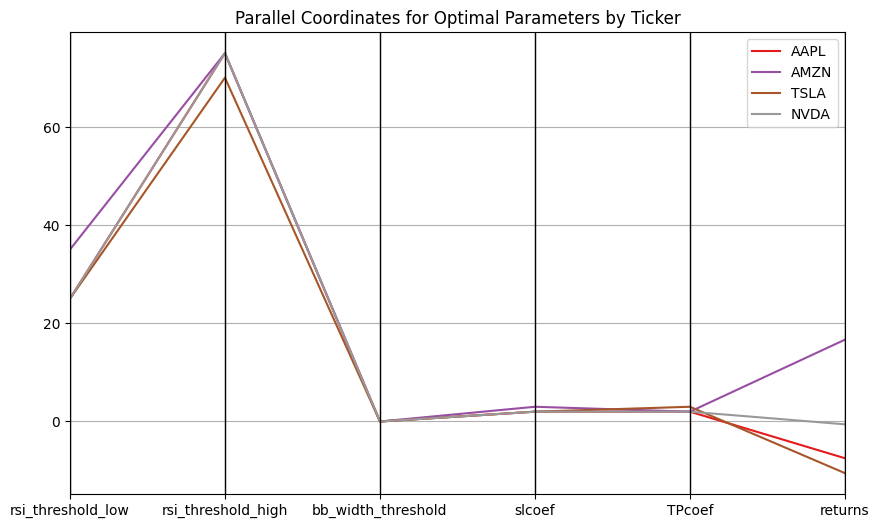

In [8]:
data_list = []
for (ticker, stats, bt) in results:
    data_list.append({
        "Ticker": ticker,
        "rsi_threshold_low": stats._strategy.rsi_threshold_low,
        "rsi_threshold_high": stats._strategy.rsi_threshold_high,
        "bb_width_threshold": stats._strategy.bb_width_threshold,
        "slcoef": stats._strategy.slcoef,
        "TPcoef": stats._strategy.TPcoef,
        "returns": stats["Return [%]"]
    })

df_params = pd.DataFrame(data_list)
print("\n==== df_params (for parallel coordinates) ====")
print(df_params)

# Make sure df_params is not empty before plotting
if not df_params.empty:
    plt.figure(figsize=(10, 6))
    parallel_coordinates(
        df_params,
        class_column='Ticker',
        cols=["rsi_threshold_low","rsi_threshold_high","bb_width_threshold","slcoef","TPcoef","returns"],
        colormap=plt.get_cmap("Set1")
    )
    plt.title("Parallel Coordinates for Optimal Parameters by Ticker")
    plt.grid(True)
else:
    print("df_params is empty, so no parallel coordinates plot can be drawn.")

plt.show() # shows all figures at once at the end 


